In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from copy import deepcopy
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')


## Hyperparameters

In [ ]:
sma_roll = 0

batch_size = 32
seq_len = 72
n_epochs = 5

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

## Load stock data again, to apply rolling window

In [33]:
stock = pd.read_csv('meta.us.txt')
stock.columns = ['TICKER','PER','DATE','TIME','OPEN','HIGH','LOW','CLOSE','VOL','OPENINT']
stock['TIME'] = pd.to_datetime(stock['TIME'],format= '%H%M%S' ).dt.time
stock['DATE'] = pd.to_datetime(stock['DATE'],format='%Y%m%d').dt.date
stock['DATE'] = pd.to_datetime(stock['DATE'].apply(str)+' '+stock['TIME'].apply(str))

# Replace 0 to avoid dividing by 0 later on
stock['VOL'].replace(to_replace=0, method='ffill', inplace=True) 
stock.sort_values('DATE', inplace=True)

# Assign df
df = deepcopy(stock)

# Apply moving average to all columns
if sma_roll > 0:
    df[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']] = df[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']].rolling(sma_roll).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
df.head()

,TICKER,PER,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,OPENINT
0,META.US,60,2021-12-30 16:00:00,16:00:00,344.00,345.700,343.22,345.275,1227974,0
1,META.US,60,2021-12-30 17:00:00,17:00:00,345.29,346.570,344.75,344.750,1365663,0
2,META.US,60,2021-12-30 18:00:00,18:00:00,344.80,345.383,344.17,345.366,755072,0
3,META.US,60,2021-12-30 19:00:00,19:00:00,345.37,345.900,345.13,345.493,544627,0
4,META.US,60,2021-12-30 20:00:00,20:00:00,345.49,346.696,345.28,346.535,565582,0


## Plot daily stock closing prices and volume

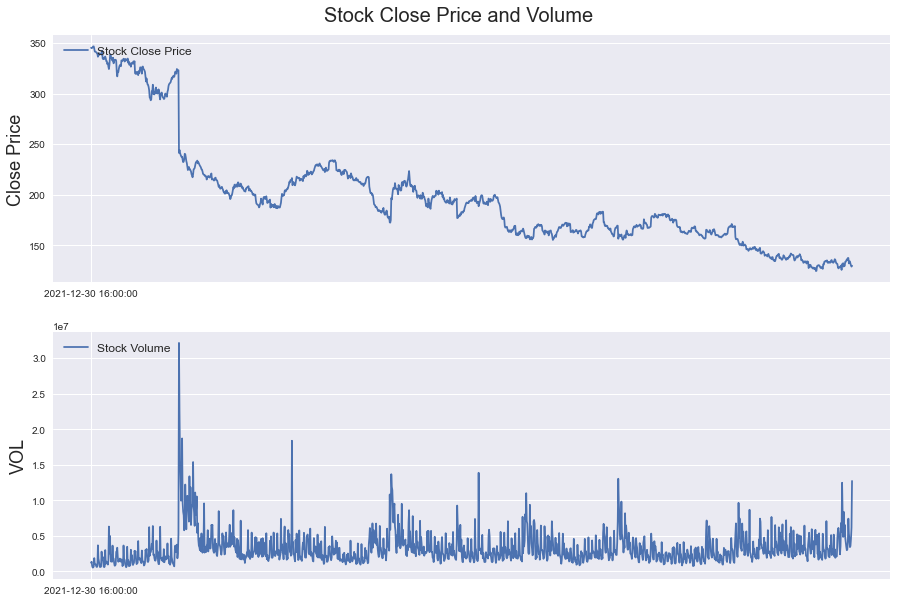

In [34]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Stock Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['CLOSE'], label='Stock Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['DATE'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['VOL'], label='Stock Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['DATE'].loc[::1464])
ax2.set_ylabel('VOL', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## Calculate normalized percentage change for all columns

In [35]:
'''Calculate percentage change'''
df['OPEN'] = df['OPEN'].pct_change() # Create arithmetic returns column
df['HIGH'] = df['HIGH'].pct_change() # Create arithmetic returns column
df['LOW'] = df['LOW'].pct_change() # Create arithmetic returns column
df['CLOSE'] = df['CLOSE'].pct_change() # Create arithmetic returns column
df['VOL'] = df['VOL'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series
last_30pct = sorted(df.index.values)[-int(0.3*len(times))] # Last 30% of series
last_40pct = sorted(df.index.values)[-int(0.4*len(times))] # Last 40% of series
last_50pct = sorted(df.index.values)[-int(0.5*len(times))] # Last 50% of series
last_60pct = sorted(df.index.values)[-int(0.6*len(times))] # Last 60% of series
last_70pct = sorted(df.index.values)[-int(0.7*len(times))] # Last 70% of series
last_80pct = sorted(df.index.values)[-int(0.8*len(times))] # Last 80% of series
last_90pct = sorted(df.index.values)[-int(0.9*len(times))] # Last 90% of series

###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['OPEN', 'HIGH', 'LOW', 'CLOSE']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['OPEN', 'HIGH', 'LOW', 'CLOSE']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['OPEN'] = (df['OPEN'] - min_return) / (max_return - min_return)
df['HIGH'] = (df['HIGH'] - min_return) / (max_return - min_return)
df['LOW'] = (df['LOW'] - min_return) / (max_return - min_return)
df['CLOSE'] = (df['CLOSE'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['VOL'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['VOL'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['VOL'] = (df['VOL'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_40pct)]  # Training data are % of total data
df_val = df[(df.index >= last_40pct) & (df.index < last_20pct)]
df_test = df[(df.index >= last_20pct)]

# Remove TICKER column
df_train.drop(columns=['TICKER'], inplace=True)
df_val.drop(columns=['TICKER'], inplace=True)
df_test.drop(columns=['TICKER'], inplace=True)

# Remove PER column
df_train.drop(columns=['PER'], inplace=True)
df_val.drop(columns=['PER'], inplace=True)
df_test.drop(columns=['PER'], inplace=True)

# Remove DATE column
df_train.drop(columns=['DATE'], inplace=True)
df_val.drop(columns=['DATE'], inplace=True)
df_test.drop(columns=['DATE'], inplace=True)

# Remove TIME column
df_train.drop(columns=['TIME'], inplace=True)
df_val.drop(columns=['TIME'], inplace=True)
df_test.drop(columns=['TIME'], inplace=True)

# Remove OPENINT column
df_train.drop(columns=['OPENINT'], inplace=True)
df_val.drop(columns=['OPENINT'], inplace=True)
df_test.drop(columns=['OPENINT'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (873, 5)
Validation data shape: (291, 5)
Test data shape: (291, 5)


,OPEN,HIGH,LOW,CLOSE,VOL
1,0.599017,0.596255,0.600602,0.587215,0.116780
2,0.587442,0.582950,0.586853,0.594621,0.044697
3,0.594322,0.593972,0.596866,0.591443,0.066402
4,0.591398,0.595773,0.591593,0.597373,0.107286
5,0.597620,0.594069,0.594835,0.590523,0.135782


In [36]:
###############################################################################
'''Create training, validation and test split'''
stock.drop(labels=0, inplace=True)
stock.drop(columns=['TICKER'], inplace=True)
stock.drop(columns=['PER'], inplace=True)
stock.drop(columns=['DATE'], inplace=True)
stock.drop(columns=['TIME'], inplace=True)
stock.drop(columns=['OPENINT'], inplace=True)

stock_train = stock[(df.index < last_40pct)]  # Training data are % of total data
stock_val = stock[(df.index >= last_40pct) & (df.index < last_20pct)]
stock_test = stock[(df.index >= last_20pct)]

# Convert pandas columns into arrays
stock_train_data = stock_train.values
stock_val_data = stock_val.values
stock_test_data = stock_test.values
print('Stock Training data shape: {}'.format(stock_train_data.shape))
print('Stock Validation data shape: {}'.format(stock_val_data.shape))
print('Stock Test data shape: {}'.format(stock_test_data.shape))

Stock Training data shape: (873, 5)
Stock Validation data shape: (291, 5)
Stock Test data shape: (291, 5)


## Plot daily changes of close price and volume

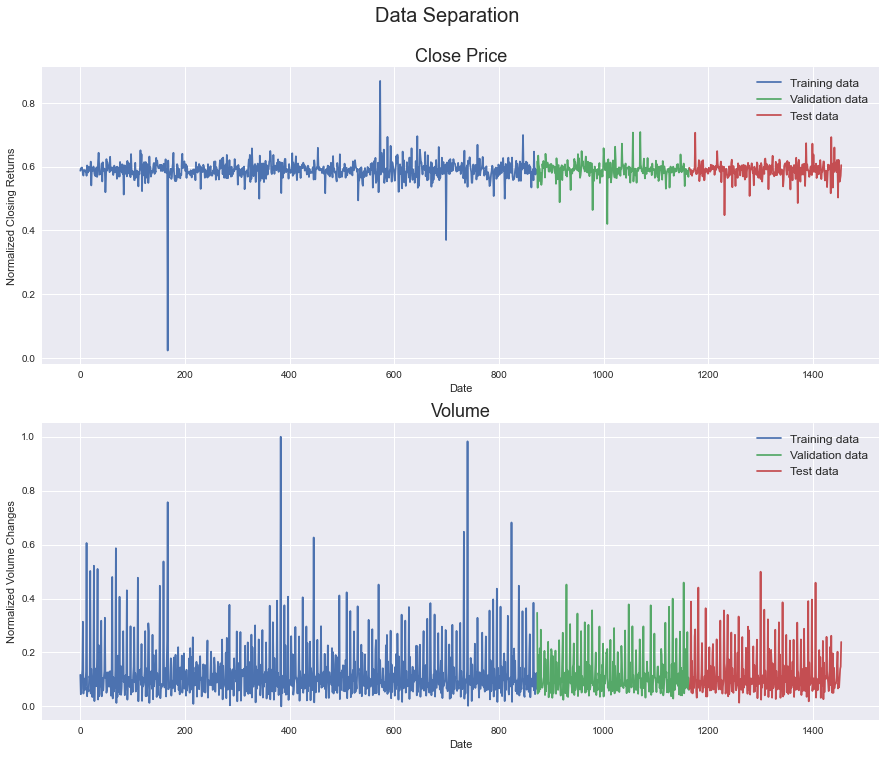

In [39]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['CLOSE'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['CLOSE'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['CLOSE'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['VOL'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['VOL'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['VOL'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## Create chunks of training, validation, and test data

In [40]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(801, 72, 5) (801,)
(219, 72, 5) (219,)


## TimeVector

In [41]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

## Transformer

In [42]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

## Model

In [43]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding+SMA.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=n_epochs, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

model = tf.keras.models.load_model('Transformer+TimeEmbedding+SMA.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 72, 5)]      0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 72, 2)        288         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 72, 7)        0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 72, 7)        99114       concatenate[0][0]            

In [44]:
###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.0012, MAE: 0.0199, MAPE: 6.2748
Validation Data - Loss: 0.0007, MAE: 0.0167, MAPE: 2.8936
Test Data - Loss: 0.0007, MAE: 0.0188, MAPE: 3.2562


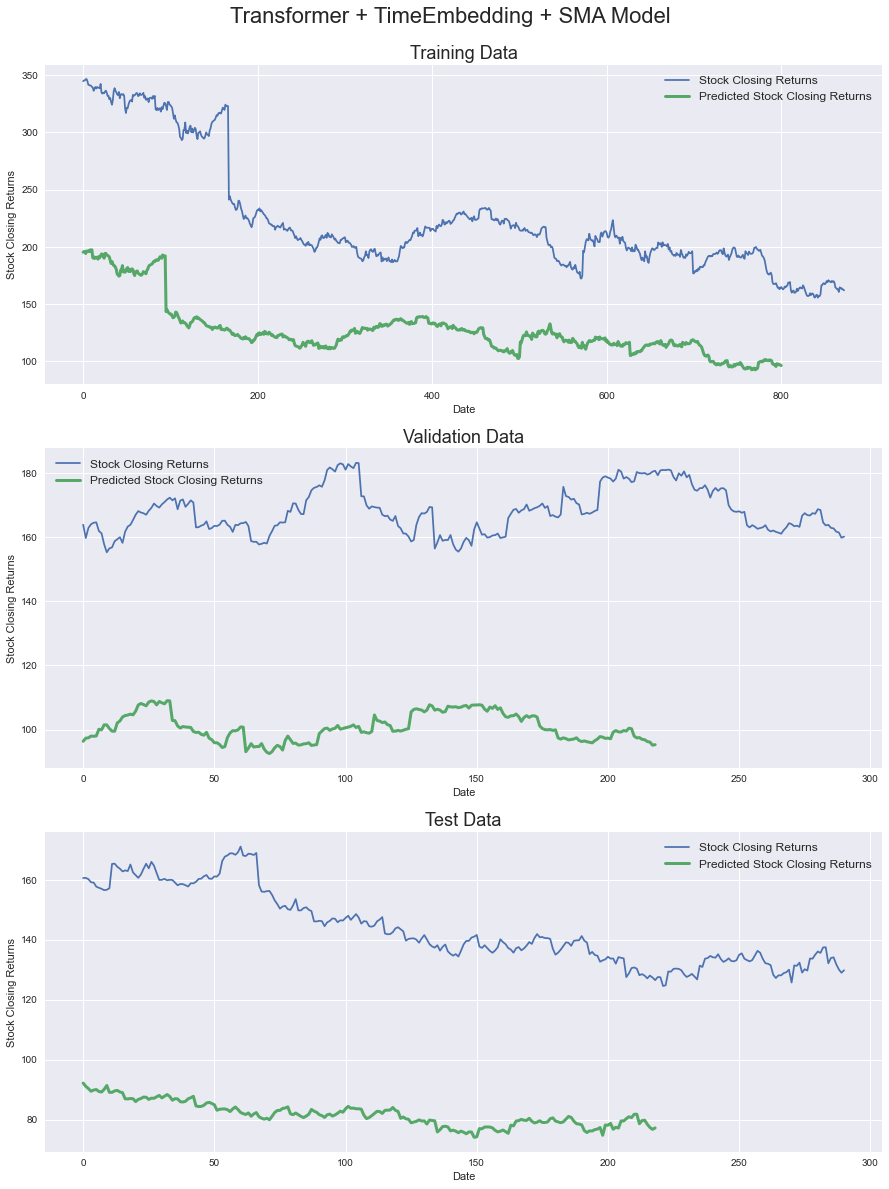

In [46]:
###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding + SMA Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(stock_train_data[:, 3], label='Stock Closing Returns')
ax11.plot(np.arange(0, train_pred.shape[0]), train_pred*stock_train_data[seq_len:, 3].reshape(len(stock_train_data[seq_len:, 3]), 1), linewidth=3, label='Predicted Stock Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Stock Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(stock_val_data[:, 3], label='Stock Closing Returns')
ax21.plot(np.arange(0, val_pred.shape[0]), val_pred*stock_val_data[seq_len:, 3].reshape(len(stock_val_data[seq_len:, 3]), 1), linewidth=3, label='Predicted Stock Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Stock Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(stock_test_data[:, 3], label='Stock Closing Returns')
ax31.plot(np.arange(0, test_pred.shape[0]), test_pred*stock_test_data[seq_len:, 3].reshape(len(stock_test_data[seq_len:, 3]), 1), linewidth=3, label='Predicted Stock Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Stock Closing Returns')
ax31.legend(loc="best", fontsize=12)

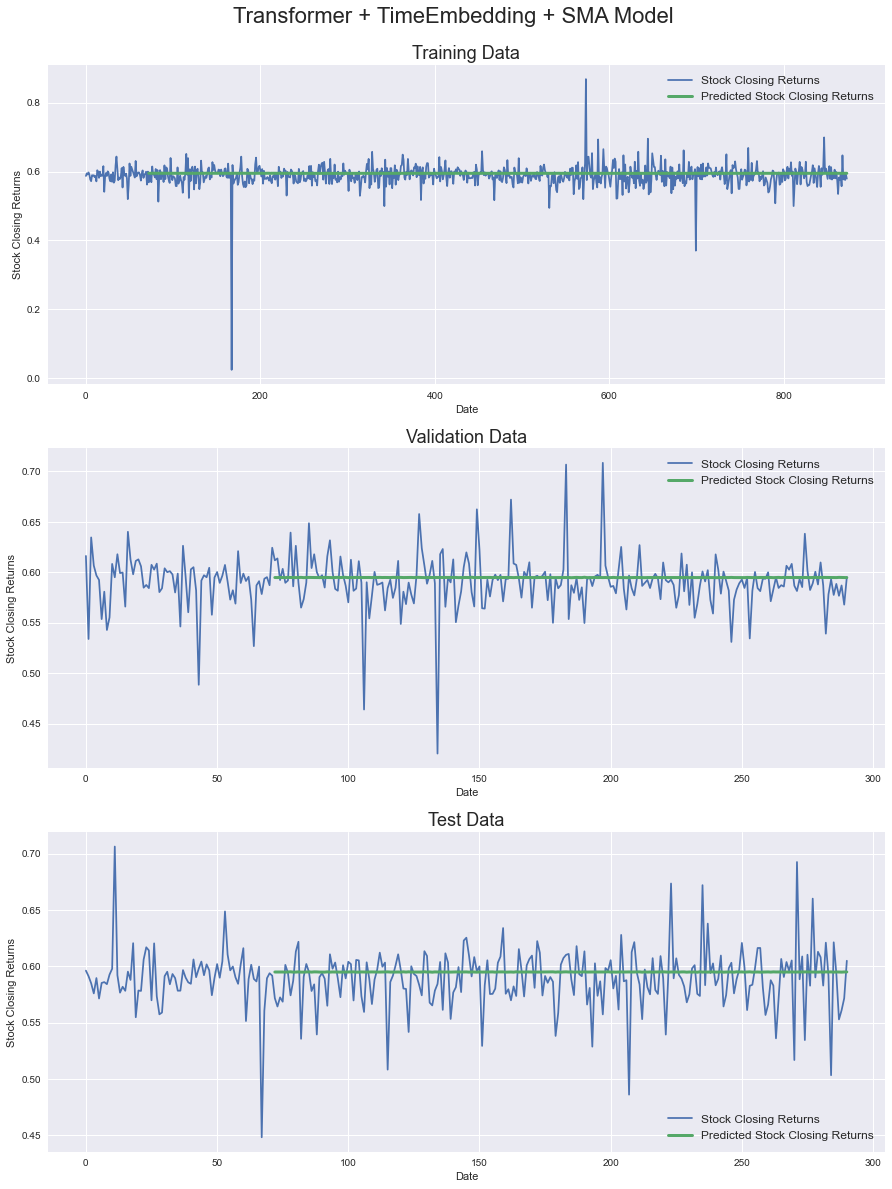

In [47]:
###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding + SMA Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Stock Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Stock Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Stock Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Stock Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Stock Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Stock Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='Stock Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Stock Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Stock Closing Returns')
ax31.legend(loc="best", fontsize=12)

## Model metrics

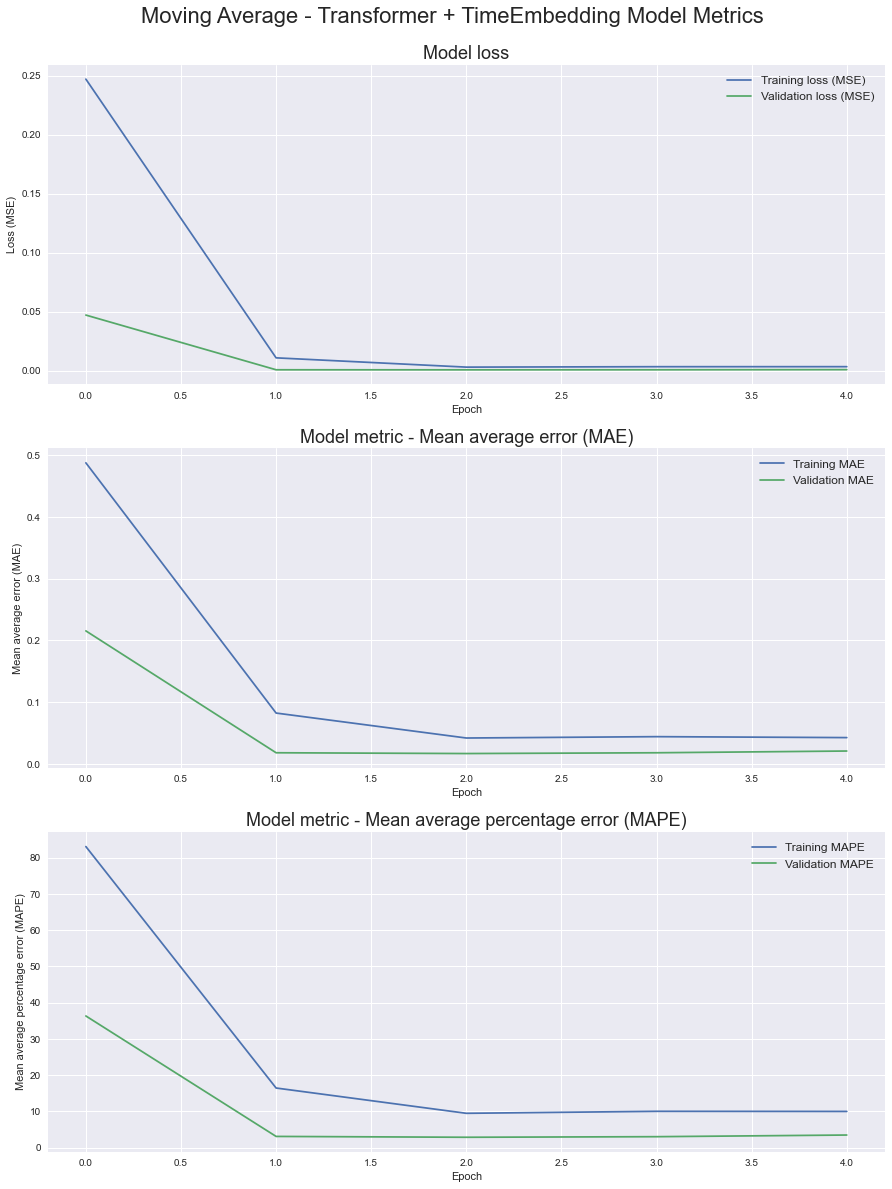

In [48]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

## Model architecture overview

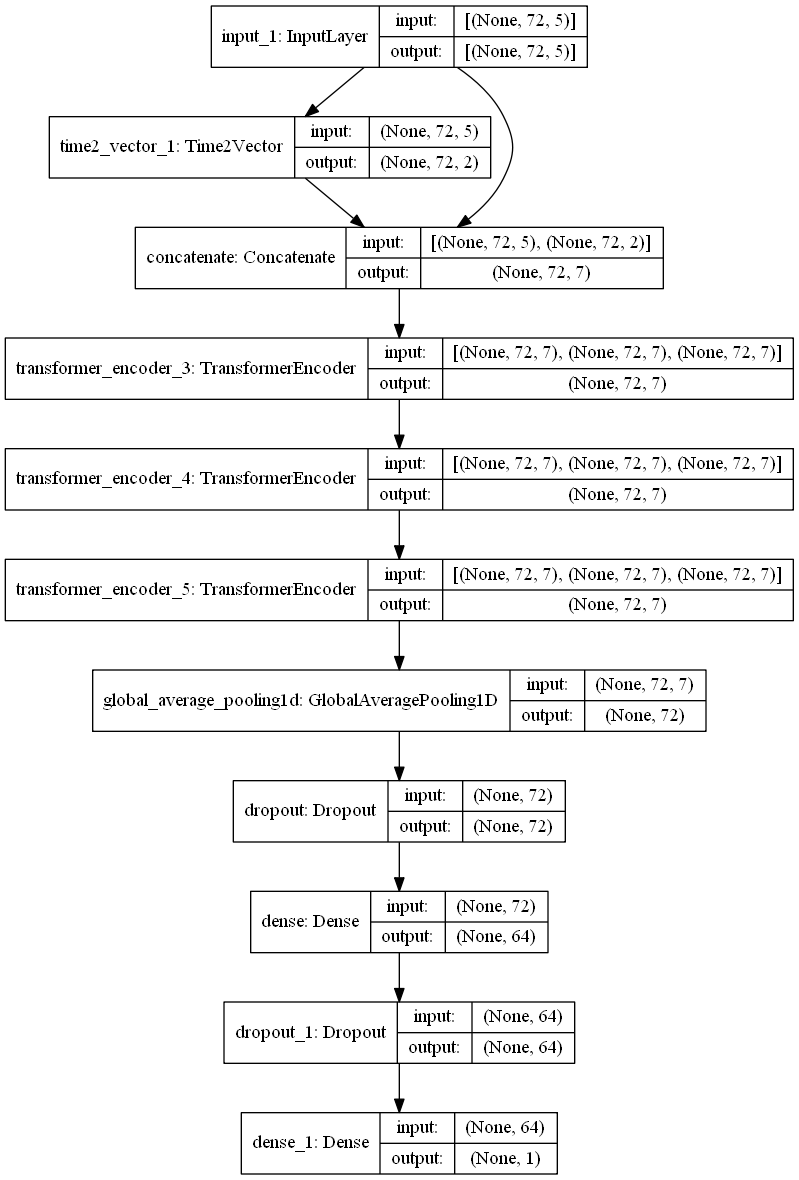

In [49]:
tf.keras.utils.plot_model(
    model,
    to_file="Stock_Transformer+TimeEmbedding+SMA.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)

## Reference  
https://towardsdatascience.com/stock-predictions-with-state-of-the-art-transformer-and-time-embeddings-3a4485237de6  
https://github.com/JanSchm/CapMarket/blob/master/bot_experiments/IBM_Transformer%2BTimeEmbedding.ipynb  